In [0]:
"""

Face Analytic (Expression) with TensorFlow  
  
Copyright 2020  I Made Agus Dwi Suarjaya, I Putu Adi Putra Setiawan, Kobar Septyanus, Ni Luh Putu Diah Putri Maheswari  
  
Description     : Try to analyze faces with TensorFlow and classify into 7 expressions (angry, disgust, fear, happy, neutral, sad, surprise)  
Dataset source  : https://www.kaggle.com/jonathanoheix/face-expression-recognition-dataset

"""

In [0]:
#!unzip -q './drive/My Drive/images.zip' -d './'
#!cp "/content/drive/My Drive/1590218618_dict" ./
#!cp "/content/drive/My Drive/1590218618_model" ./

In [0]:
import csv
import time
import ast

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from google.colab import files
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
#---------------------------
# Prepare the images dataset
#---------------------------
TRAINING_DIR = "./images/train"
train_datagen = ImageDataGenerator( rescale = 1.0/255.,
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    color_mode='grayscale',
                                                    batch_size=128,
                                                    shuffle=True,
                                                    target_size=(48, 48))

VALIDATION_DIR = "./images/validation"
validation_datagen = ImageDataGenerator( rescale = 1.0/255.,)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                         color_mode='grayscale',
                                                         batch_size=128,
                                                         shuffle=True,
                                                         target_size=(48, 48))

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [0]:
#---------------------------
# Look at the images dataset
#---------------------------
plt.figure(figsize=(10, 10))
images, labels = next(train_generator)
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.axis("off")
    for key, value in train_generator.class_indices.items():
        if value == np.argmax(labels[i]):
            plt.title(key)
plt.show()

In [0]:
#------------------------------
# Prepare and compile the model
#------------------------------
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(48, 48, 1)),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(2048, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='categorical_crossentropy', metrics=['acc'])

In [0]:
model.summary() # Summary of the model

In [0]:
#----------------
# Train the model
#----------------
def lr_scheduler(epoch, lr):
    lr = 1e-4
    return lr

callbacks = [tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)]

history = model.fit_generator(train_generator,
                              epochs=100,
                              verbose=1,
                              callbacks=callbacks,
                              validation_data=validation_generator)

In [0]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.title('Training and validation loss')

In [0]:
#------------------------------
# Save the model and Dictionary
#------------------------------
t = time.time()

export_path_model = "./{}_model".format(int(t))
model.save(export_path_model, save_format='h5')

export_path_dict = "./{}_dict".format(int(t))
with open(export_path_dict, 'w') as outfile:
    outfile.write(str(train_generator.class_indices))

In [0]:
#------------------------------
# Load the model and Dictionary
#------------------------------
reloaded_model = tf.keras.models.load_model('/content/1590218618_model')
model = reloaded_model

with open('/content/1590218618_dict') as dict_file:
    d = ast.literal_eval(dict_file.readline())

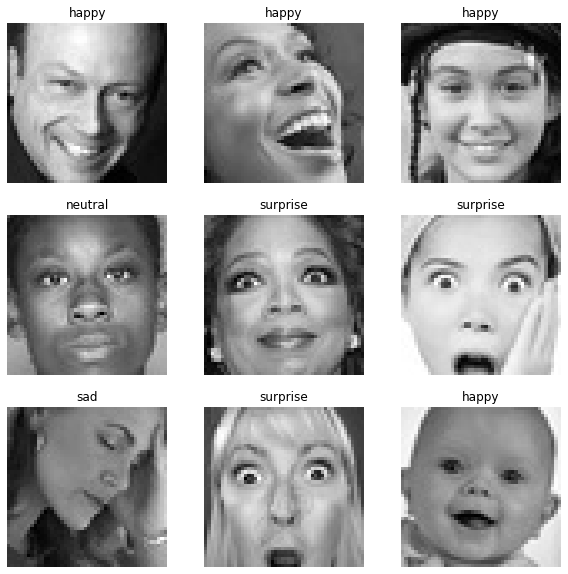

In [5]:
#----------------------------------------------
# Predict and plot some images (From Generator)
#----------------------------------------------
plt.figure(figsize=(10, 10))
images, labels = next(validation_generator)
prediction = model.predict(images)

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.axis("off")
    for key, value in d.items():
        if value == np.argmax(prediction[i]):
            plt.title(key)

plt.show()

Saving 6.jpg to 6.jpg
Saving 7.jpg to 7.jpg


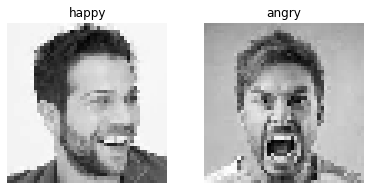

In [8]:
#------------------------------------------
# Predict and plot some images (From Colab)
#------------------------------------------
uploaded = files.upload()
plt.figure(figsize=(10, 10))

for i, fn in enumerate(uploaded.keys()):
  path = '/content/' + fn
  img = image.load_img(path, target_size=(48, 48), color_mode="grayscale")
  x = image.img_to_array(img)/255
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  prediction = model.predict(images)
  plt.subplot(3, 3, i + 1)
  plt.imshow(images.squeeze(), cmap='gray')
  plt.axis("off")
  for key, value in d.items():
      if value == np.argmax(prediction[0]):
          plt.title(key)

plt.show()

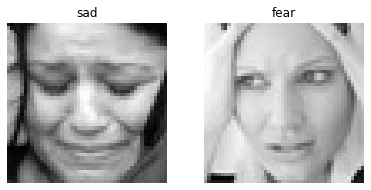

In [6]:
#--------------------------------------------
# Predict and plot some images (From Local)
#--------------------------------------------
images_path = {'/content/images/validation/sad/32613.jpg',
               '/content/images/validation/fear/2226.jpg'}

plt.figure(figsize=(10, 10))

for i, fn in enumerate(images_path):
  path = fn
  img = image.load_img(path, target_size=(48, 48), color_mode="grayscale")
  x = image.img_to_array(img)/255
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  prediction = model.predict(images)
  plt.subplot(3, 3, i + 1)
  plt.imshow(images.squeeze(), cmap='gray')
  plt.axis("off")
  for key, value in d.items():
      if value == np.argmax(prediction[0]):
          plt.title(key)

plt.show()